# Introduction to the Article Code:

This is the code used for the article posted on Medium.com. If you would like to know more about it click the link: [CRISP-DM Regression Analysis in Python](https://medium.com/p/ade4b74bdc85/edit)

In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from helper import cleaning_dollar
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import durbin_watson
from helper import iqr_outlier_detect

<a id="extract"></a>

# Extracting and Merging the data:

## Calendar

In [16]:
os.getcwd()

'D:\\GitHub\\Airbnb_ML'

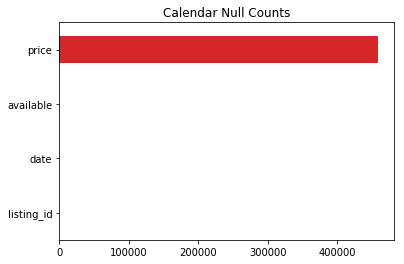

In [10]:
# Extracting the calendar dataset
df_calendar = pd.read_csv('data\calendar.csv')

# Extracting the listings dataset
target_col = ['id', 'accommodates', 'bedrooms', 'cleaning_fee', 'property_type']
df_listings = pd.read_csv('data\listings.csv')[target_col]

# Calculating null values
null_calendar = df_calendar.isnull().sum()
null_listings = df_listings.isnull().sum()

# Show Nulls on Graph
null_calendar.plot.barh(title='Calendar Null Counts');

In [13]:
pd.to_datetime(df_calendar.date).describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

The only feature in the calendar dataset having nulls is price.

## Listings

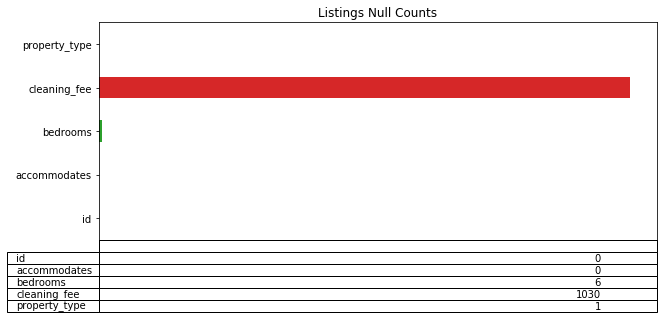

In [4]:
# Plot settings
ax = plt.subplot(111, frame_on=True) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

# Adding Table
table(ax, null_listings)

# Showing Graph
null_listings.plot.barh(title='Listings Null Counts', figsize=(10,4));

The most noticeable feature having nulls is the cleaning fee. Bedrooms and property types have insignificant null values. However, instead of just removing these, we are imputing them for the sake of example. 

<a id="tran"></a>

# Transforming and Cleaning the data:

## Calendar

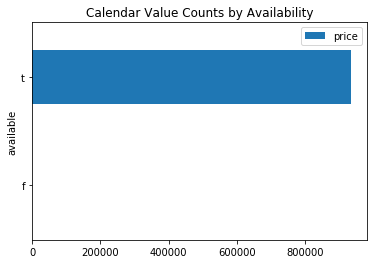

In [5]:
# Cleaning price
df_calendar.loc[:, 'price'] = df_calendar.price.str.findall(
    '[^$,]').str.join('').astype(float)

# Grouping prices by the available feature
df_calendar.groupby('available').count()[['price']].plot.barh(
    title="Calendar Value Counts by Availability");

Where the prices are null in the calendar dataset, the availability is false (f). This means that the unavailable listings have no price at all. The nulls here are meaningful.

In [6]:
# Dropping where available is f
df_calendar = df_calendar.where(lambda x: x.available=='t').dropna()

# Kepp only usefull features for the analysis
df_calendar = df_calendar[['listing_id', 'price', 'date']]

We ended up dropping the null prices because we will waste our time predicting $0 prices when the listing is not available. Thus, the availability feature ended populated with just True conditions (t). So we dropped it.

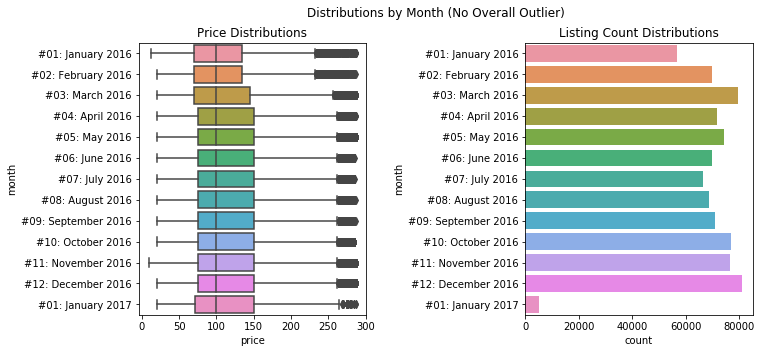

In [7]:
# Converting date to date time
df_calendar.loc[:, 'date'] = df_calendar.date.apply(pd.to_datetime)

# Adding the months ot sort on Graph
month_format = lambda x: f"#{x.month:0>2}" + ': ' + x.month_name() + ' ' +str(x.year)
month_func = lambda x: x.date.apply(month_format)
df_calendar = df_calendar.assign(month=month_func)

# Plotting settings
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))

plt.suptitle('Distributions by Month (No Overall Outlier)')
plt.subplots_adjust(wspace=.7)

# Statistical outlier removal
upper_quartile = df_calendar.price.quantile(.75)
lower_quartile = df_calendar.price.quantile(.25)
interquartile =  upper_quartile - lower_quartile
lower_whisker = lower_quartile - interquartile * 1.5
upper_whisker = upper_quartile + interquartile * 1.5

# Data without outlier to plot
df_calendar_noout = df_calendar.query(
    f"price<={upper_whisker} and price>={lower_whisker}")

# Plotting 
ax[0].set_title('Price Distributions')
sns.boxplot(x='price', y='month', data=df_calendar_noout, ax=ax[0]);

ax[1].set_title('Listing Count Distributions')
sns.countplot(y='month', data=df_calendar_noout, ax=ax[1]);

In [8]:
df_calendar.date.describe()

count                  934542
unique                    365
top       2017-01-01 00:00:00
freq                     2922
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

We answered the first business question with this graphs. Which months have higher prices? Here, we are talking about the listing prices. Thus, to show each particular prices by month (not aggregates), the best way is to provide their distributions. However, to know how complete is the data, we needed to check the listing counts per month. For example, January 2017 is definitely not completed. In fact it only has 2 days of data. Perhaps after completing the month, January 2017 ends up being higher than December 2016. Thus, we cannot use January 2017 to compare.

In [ ]:
# Save date references
dates = pd.Series(df_calendar.date.unique())
date_order = pd.Series(df_calendar.date.unique()).rank()
date_ref_df = pd.concat([dates, date_order], axis=1)
date_ref_df.columns = ['dates', 'date_order']

# Transforming dates to ordered values
df_calendar.loc[:, 'date'] = df_calendar.date.rank(method='dense')

# Dropping irrelevant columns
df_calendar.drop('month', axis=1, inplace=True)

We saved the original dates and the related ranking for reference.

## Listings 

In [ ]:
# Cleaning cleaning fee
df_listings.loc[:, 'cleaning_fee'] = df_listings.cleaning_fee.str.findall(
    '[^$,]').str.join('').astype(float)

The only field needing cleanup is the cleaning fee.

<a id="impute"></a>

# Imputation of the Data:

## Bedroom Imputations

In [ ]:
# Get mode by group into dictionary
mode = df_listings.groupby('property_type').bedrooms.apply(
    lambda x: x.value_counts().index[0]).to_dict()

# Assign the mode by mapping
mode_fill = df_listings.assign(
    bedrooms=lambda x: x.property_type.map(mode)).bedrooms

# Fill the nulls with respective modes by property_type
df_listings.bedrooms.fillna(mode_fill, inplace=True)

# Show modes by category
pd.DataFrame(mode, index=[0]).T.rename(columns={0: 'Mode'})

By chance, most of property type's most common number of bedrooms is 1.

## Cleaning Fees Imputations

In [ ]:
df_listings.cleaning_fee.fillna(0, inplace=True)

We are assuming null cleaning fees are just $0 cleaning fees.

## Property Type Sparsity Groupings

In [ ]:
df_listings.property_type.value_counts(
    normalize=True, dropna=False, ascending=True
    ).plot.barh(title='Sparsity of Property Types');

In [ ]:
# Leaving relevant classes and assigning all other to Other
fn_keep_labels = lambda x: x.str.contains('House|Apartment')
df_listings.loc[:, 'property_type'] = df_listings.property_type.where(
    fn_keep_labels).fillna('Other')

# Plotting new classes
df_listings.property_type.value_counts(
    normalize=True, dropna=False, ascending=True
    ).plot.barh(title='New Classes of Property Types');

<a id="encode"></a>

# Encoding the Data:

In [ ]:
# Instantiating Encoder
encoder = OneHotEncoder()

# Encoding property types
encode_matrix = encoder.fit_transform(df_listings[['property_type']])

# Dropping original column
df_listings.drop('property_type', axis=1, inplace=True)

# Converting encoded data to dataframe
endoce_df = pd.DataFrame(encode_matrix.toarray(), columns=encoder.categories_[0])

# Adding columns to dataframe
df_listings = pd.concat([df_listings, endoce_df], axis=1)

In [ ]:
endoce_df.head()

In [ ]:
df_listings.head()

The property type was encoded as dummy variables so the model can run.

<a id="assess"></a>

#  Assessing the Data Model

In [ ]:
# Creating the final Seattle data
df_seattle = df_calendar.merge(df_listings, 
                               left_on='listing_id',
                               right_on='id', 
                               how='left')

# Dropping keys
df_seattle.drop(['id', 'listing_id'], axis=1, inplace=True)

# Plotting correlations
plt.figure(figsize=(10, 10))
plt.title("Correlation with Price and Multicollinearity within Predictors")
sns.heatmap(df_seattle.corr(), annot=True);

The encoded columns ended up not providing any value to the model. In addition, two of them have high multicollinearity. Thus, we are removing them.

In [ ]:
# Droping encoded columns
df_seattle.drop(['Apartment', 'House', 'Other'], axis=1, inplace=True)

<a id="models"></a>

# Applying and Evaluating Model

In [ ]:
def apply_model(dataframe):
    """
    There are two models applying here:
        - Linear Regression
        - Random Forest Regression with 1000 n_estimators
    
    parameter
    ---------
    dataframe : the dataframe containing both the dependent and independent variables
    """
    # Instantiating model and cv
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=1000)
    tss = TimeSeriesSplit(n_splits=5)
    
    # Resetting index for the cross validation
    dataframe.reset_index(drop=True, inplace=True)

    # Sorting time series
    dataframe = dataframe.sort_values('date')

    # Separating predictors and dependent variable
    X = dataframe.drop('price', axis=1)
    y = dataframe[['price']]
    
    score_dict = {}

    # Magic
    for test_num, split_index in enumerate(tss.split(X), 1):
        train_index, test_index = split_index 

        # Split descriptors
        min_train_idx, max_train_idx = train_index.min(), train_index.max()
        min_test_idx, max_test_idx = test_index.min(), test_index.max()
        train_pct = max_train_idx / X.shape[0]
        test_pct = (max_test_idx - min_test_idx) / X.shape[0]

        print(f"SPLIT {test_num}:", 
              f"TRAIN {min_train_idx} to {max_train_idx} or {train_pct:2.2%} |",
              f"TEST {min_test_idx} to {max_test_idx} or {test_pct:2.2%}")

        # Time series split
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit
        lr.fit(X_train, y_train)    
        rf.fit(X_train, y_train.values.ravel())    

        # Linear Predict
        y_hat_linear = lr.predict(X_test)       

        # Forest Predict
        y_hat_forest = rf.predict(X_test)

        def evaluate_model(model, model_name, y_pred):
            """

            """
            score = model.score(X_test, y_test)
            score_dict.setdefault(model_name, [])
            score_dict[model_name].append(score)
            residuals = y_test - y_pred.reshape(-1, 1)
            MSE = mean_squared_error(y_test, y_pred)
            d_w = durbin_watson(residuals)[0] 

            print('-'*70)
            print(f"\tModel: {model_name}")
            print(f"\tCoefficient of Determinaion: {score:2.2%}",
                  f"\n\tMean Squared Errors: {MSE:2,.2f}",
                  f"\n\tDurbin-Watson: {d_w:2.1f}")            

        linear_model_name = 'Linear Regression'
        evaluate_model(lr, linear_model_name, y_hat_linear)

        forest_model_name = 'Random Forest Regressor'
        evaluate_model(rf, forest_model_name, y_hat_forest)

        print('_'*70)

    print(f"The linear average score is {np.mean(score_dict[linear_model_name]):2.2%}")
    print(f"The forest average score is {np.mean(score_dict[forest_model_name]):2.2%}")

In [ ]:
apply_model(df_seattle)

The score is better for the Random Forest Regression. However, we can do better by removing outliers.

## Outlier Analysis

In [ ]:
iqr_outlier_detect(df_seattle.price)

Indeed, there are many outliers in this dataset. However, let's start by looking for patterns in the top outliers.

In [ ]:
df_calendar.query("price>1100").groupby(['listing_id', 'price']).size().to_frame('ListingCount')

We can quickly observe that most of the outliers are concentrated in one listing for the same host. 

In [ ]:
plt.figure(figsize=(10, 10));

data = df_calendar 
plt.title("Seattle Listing Prices Over Date Numbers")
sns.scatterplot(x='date', 
                y='price', 
                data=data,
                color='black',
                alpha=.1, 
                label='Other Listings');

data = df_calendar.query("listing_id == '3308979'")
plt.title("Seattle Listing for Host with Outliers")
sns.scatterplot(x='date', 
                y='price', 
                data=data,
                color='red',
                label='Listing# 3308979');

data = df_calendar.query("listing_id == '7733192'")
plt.title("Seattle Listing for Host with Outliers")
sns.scatterplot(x='date', 
                y='price', 
                data=data,
                color='blue',
                label='Listing# 7733192');

We can see the density is at the bottom of the graph and there are some listings unlikely to happen at the top. In fact, these points at the top are concentrated in two listings. This is unlikely to happen in general, so it is bad for prediction. We are removing those ones.

In [ ]:
df_seattle = df_seattle.query("price < 1100")

In [ ]:
iqr_outlier_detect(df_seattle.price)

In [ ]:
plt.figure(figsize=(10, 10));

sns.scatterplot(x='date', 
                y='price', 
                data=df_seattle,
                color='black',
                alpha=.1);

We still observe some outliers, but these outliers are part of the noise and valid for the analysis.

## Re-run Model with Outliers Removed

In [ ]:
apply_model(df_seattle)

We don't see substantial improvement in the models to justify the removal of the outliers. With them or without them, the model performs about the same.